In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 740 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 165 files belonging to 2 classes.


In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# CLASS WEIGHTS

In [13]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

In [9]:
class_weights_dict

{0: 0.048648648648648596, 1: 0.9513513513513514}

# IMAGE AUGMENTATION

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentations for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,       # random rotation
    width_shift_range=0.2,   # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,         # shear transformation
    zoom_range=0.2,          # random zoom
    horizontal_flip=True,    # random horizontal flip
    fill_mode='nearest'      # fill strategy
)

# Convert tf.data.Dataset to a format compatible with ImageDataGenerator
def get_generator(dataset, datagen):
    for images, labels in dataset:
        yield from datagen.flow(images.numpy(), labels.numpy(), batch_size=32)

# Original Best Model: MobileNet (TL)

In [8]:
from tensorflow.keras.applications import MobileNet

In [11]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)

In [12]:
train_generator = get_generator(prep_train_data, train_datagen)

### Without class weights

In [68]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


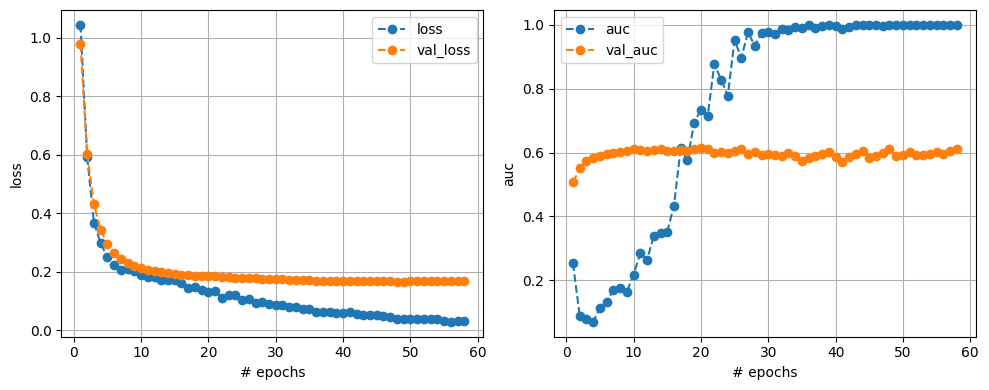

24/24 [==============================] - 4s 150ms/step - loss: 0.0305 - auc: 1.0000 - val_loss: 0.1678 - val_auc: 0.6106
Training time: 200.24316263198853 seconds


In [69]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.10 with F1-score: 0.42


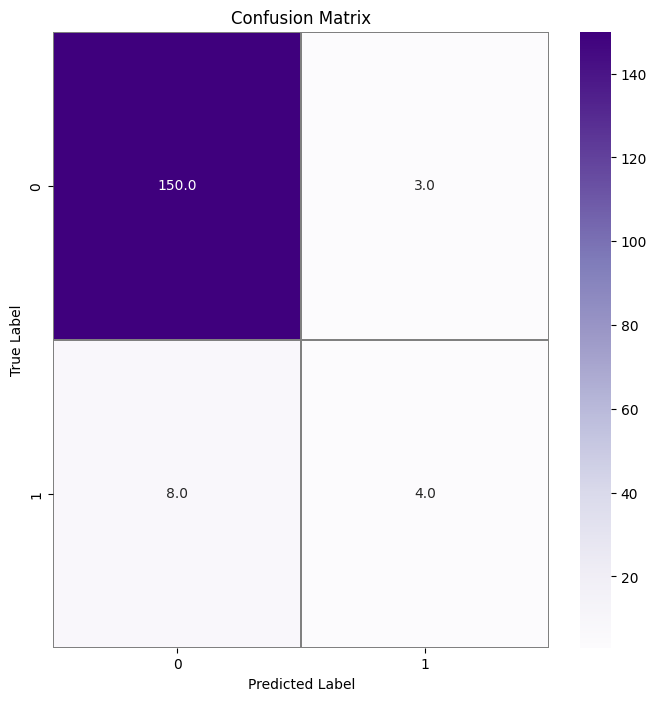

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       153
           1       0.57      0.33      0.42        12

    accuracy                           0.93       165
   macro avg       0.76      0.66      0.69       165
weighted avg       0.92      0.93      0.93       165

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL-no-CW  0.79                     0.42      0.93         0.33   

   Specificity   PPV   NPV   PLR   NLR  
0         0.98  0.57  0.95  17.0  0.68  


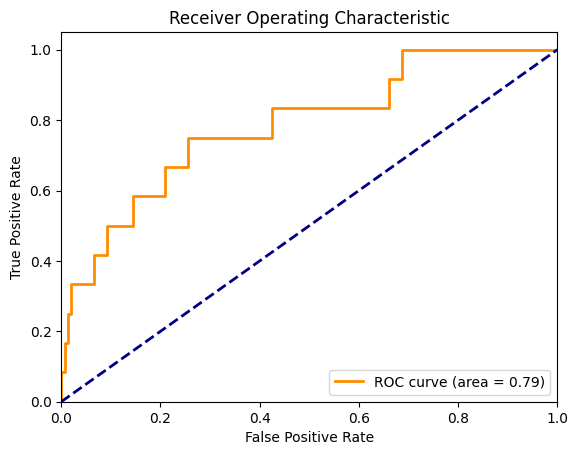

In [70]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW')

# Train on anterior placental images only

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-peso-11/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 378 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
Found 90 files belonging to 2 classes.


In [13]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)

In [14]:
train_generator = get_generator(prep_train_data, train_datagen)

In [15]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

17225924/17225924 [==============================] - 0s 0us/step
base_model.trainable set to False


### Without class weights

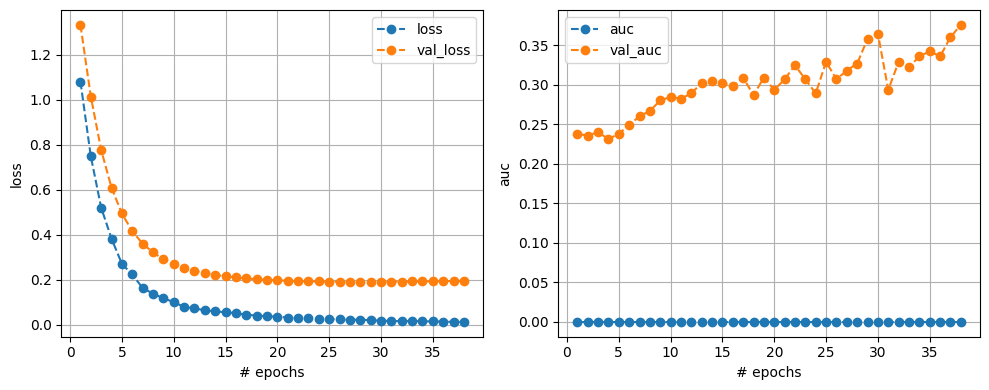

12/12 [==============================] - 2s 186ms/step - loss: 0.0127 - auc: 0.0000e+00 - val_loss: 0.1949 - val_auc: 0.3756
Training time: 96.5540542602539 seconds


In [16]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.18


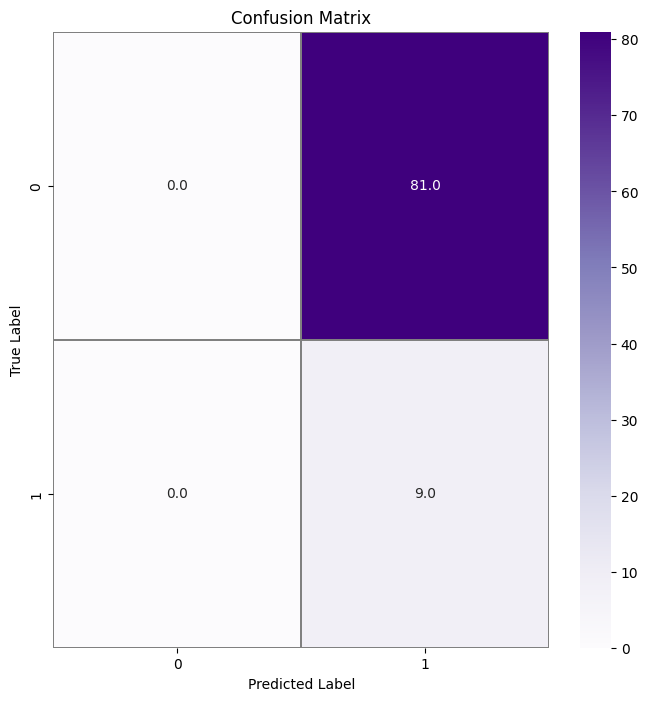

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_48/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.10      1.00      0.18         9

    accuracy                           0.10        90
   macro avg       0.05      0.50      0.09        90
weighted avg       0.01      0.10      0.02        90

                    Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-TL-no-CW-anterior  0.21                     0.18       0.1   

   Sensitivity  Specificity  PPV  NPV  PLR  NLR  
0          1.0          0.0  0.1  NaN  1.0  NaN  


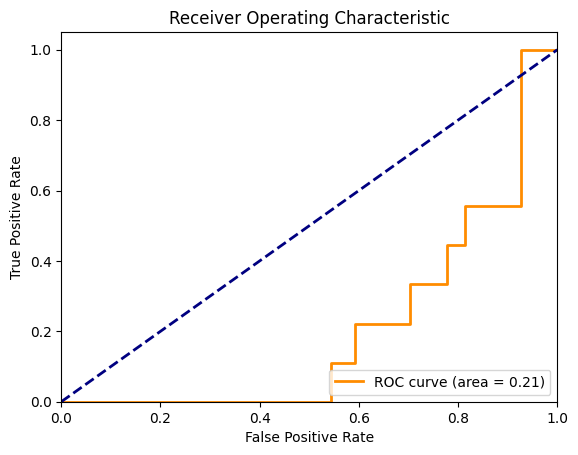

In [17]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW-anterior')

### With class weights

In [23]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


In [24]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

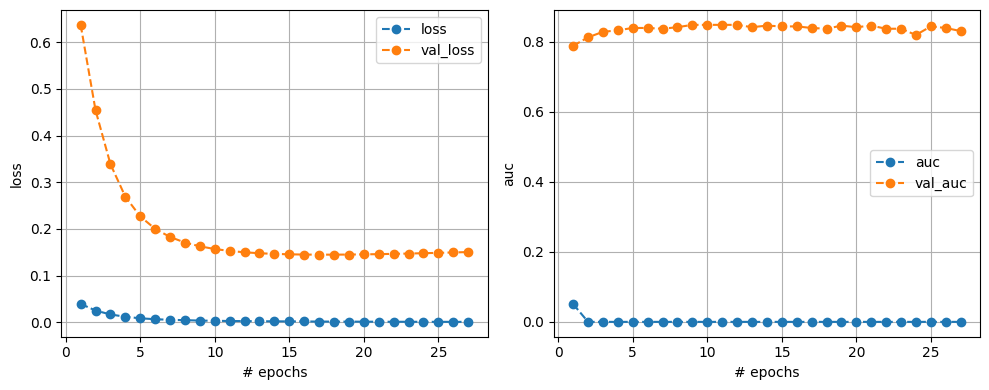

12/12 [==============================] - 2s 182ms/step - loss: 7.8145e-04 - auc: 0.0000e+00 - val_loss: 0.1504 - val_auc: 0.8311
Training time: 62.55721378326416 seconds


In [25]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.04 with F1-score: 0.22


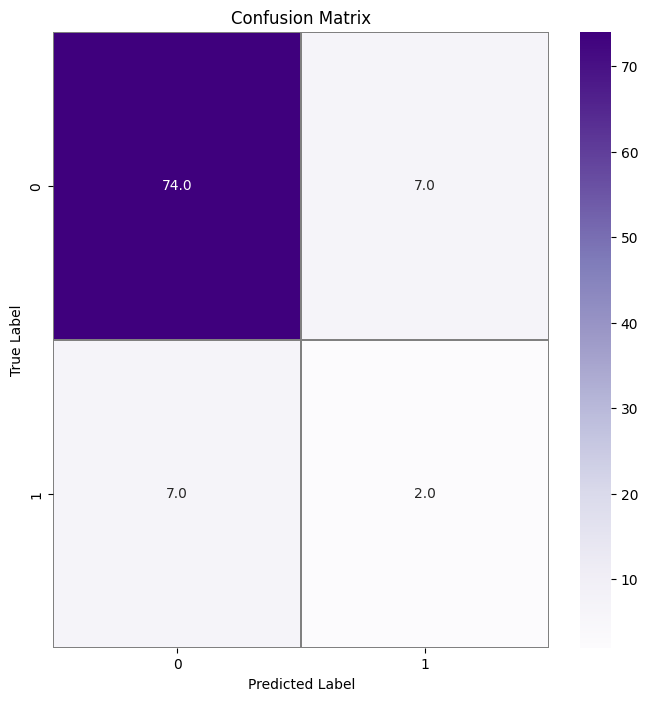

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        81
           1       0.22      0.22      0.22         9

    accuracy                           0.84        90
   macro avg       0.57      0.57      0.57        90
weighted avg       0.84      0.84      0.84        90

                 Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-TL-CW-anterior  0.54                     0.22      0.84   

   Sensitivity  Specificity   PPV   NPV   PLR   NLR  
0         0.22         0.91  0.22  0.91  2.57  0.85  


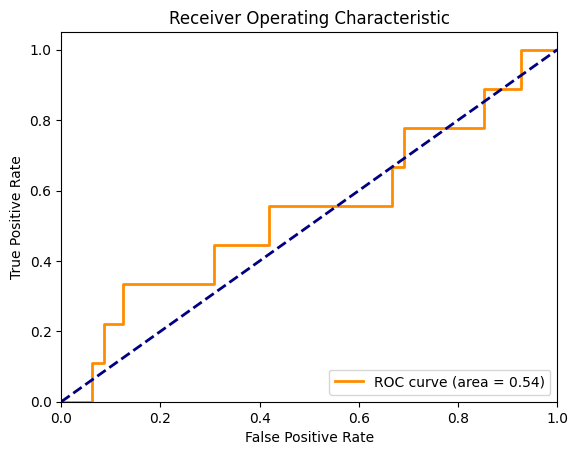

In [26]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-CW-anterior')

# Train on posterior placental images only

In [27]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-peso-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-peso-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-peso-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 356 files belonging to 2 classes.
Found 75 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [28]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)

In [29]:
train_generator = get_generator(prep_train_data, train_datagen)

### Without class weights

In [30]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


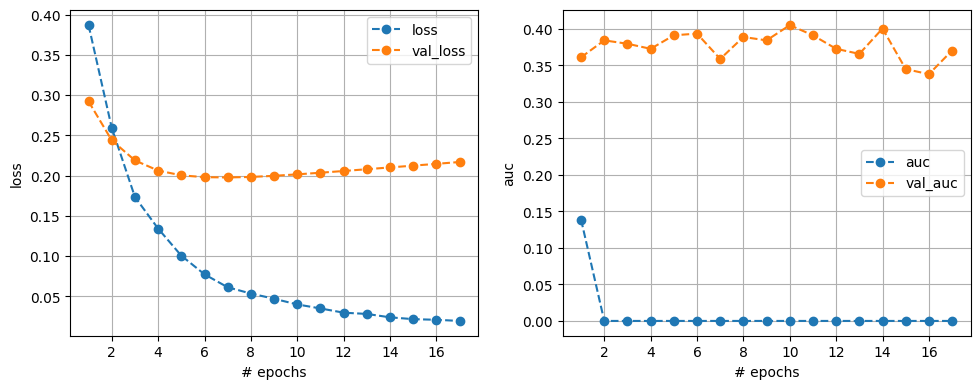

12/12 [==============================] - 2s 190ms/step - loss: 0.0196 - auc: 0.0000e+00 - val_loss: 0.2170 - val_auc: 0.3704
Training time: 43.26343750953674 seconds


In [31]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.05 with F1-score: 0.40


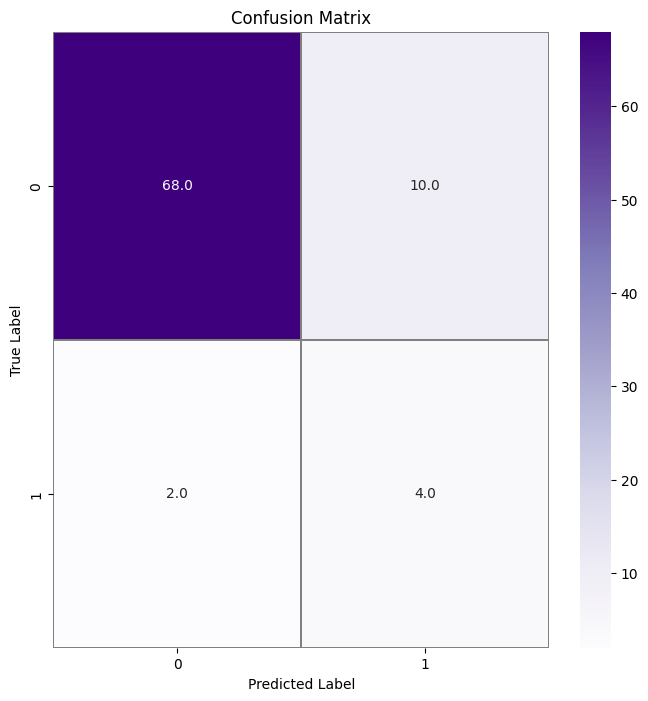

              precision    recall  f1-score   support

           0       0.97      0.87      0.92        78
           1       0.29      0.67      0.40         6

    accuracy                           0.86        84
   macro avg       0.63      0.77      0.66        84
weighted avg       0.92      0.86      0.88        84

                     Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-TL-no-CW-posterior  0.85                      0.4      0.86   

   Sensitivity  Specificity   PPV   NPV  PLR   NLR  
0         0.67         0.87  0.29  0.97  5.2  0.38  


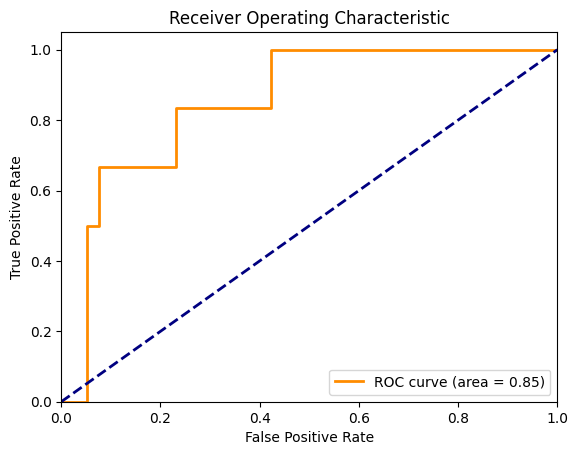

In [32]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW-posterior')

### With class weights

In [33]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

In [34]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


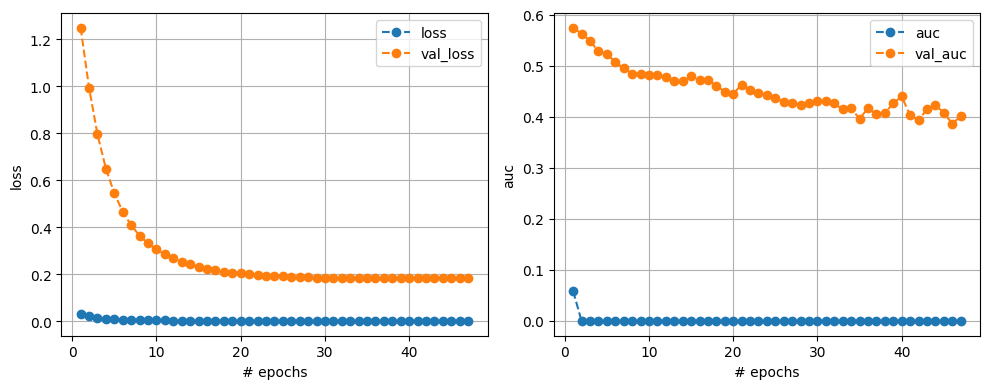

12/12 [==============================] - 2s 185ms/step - loss: 3.5294e-04 - auc: 0.0000e+00 - val_loss: 0.1850 - val_auc: 0.4005
Training time: 106.79569411277771 seconds


In [35]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.13


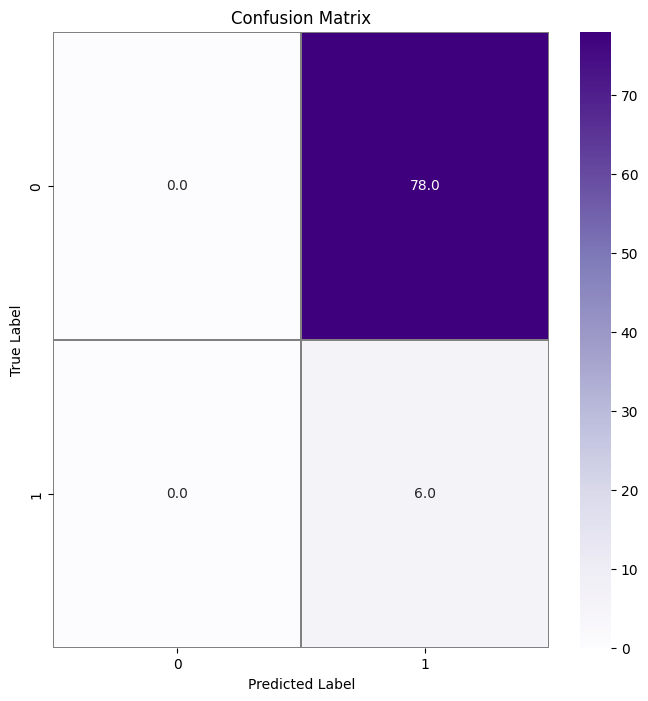

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_48/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.07      1.00      0.13         6

    accuracy                           0.07        84
   macro avg       0.04      0.50      0.07        84
weighted avg       0.01      0.07      0.01        84

                  Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-TL-CW-posterior  0.44                     0.13      0.07   

   Sensitivity  Specificity   PPV  NPV  PLR  NLR  
0          1.0          0.0  0.07  NaN  1.0  NaN  


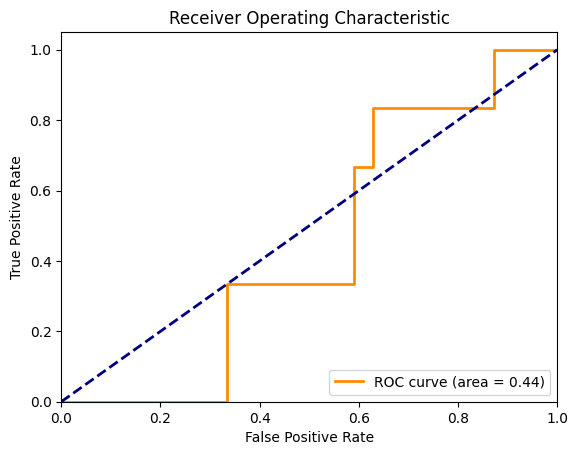

In [36]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-CW-posterior')

# Hyperparameter tuning of best model

Best model after re-training on different planes: anterior and posterior planes combined

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 740 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 165 files belonging to 2 classes.


In [10]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)

In [18]:
import optuna

def build_model(base_model, transfer_learning, trial):
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the MobileNet model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)

    # Optuna: Optimize the number of dense layers and units in each layer
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        x = Dense(trial.suggest_int('units_l{}'.format(i), 50, 200), activation='relu')(x)
        dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    # Optuna: Optimize the learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)

    # Compile the model with the suggested hyperparameters
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)

    return model

In [14]:
def objective(trial):
    # Load the base MobileNet model
    base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Build the model with suggested hyperparameters
    model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y', trial=trial)

    # Include your training and validation data generators
    train_generator = get_generator(prep_train_data, train_datagen)

    # Training setup with early stopping and checkpointing
    start = time.time()
    history = model_mobilenet.fit(train_generator,
                                  epochs=150,
                                  steps_per_epoch=len(train_data),
                                  validation_data=prep_val_data,
                                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                                             tf.keras.callbacks.ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)]
                                  )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    # Evaluate the model on the validation set
    _, auc = model_mobilenet.evaluate(prep_val_data, verbose=0)
    
    # Return the accuracy as the value to be optimized
    return auc

In [15]:
# create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2023-12-14 18:31:07,021] A new study created in memory with name: no-name-08f8e1dc-722d-45a8-ab91-c8ac0105268f


17225924/17225924 [==============================] - 0s 0us/step


/tmp/ipykernel_47/525223434.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_47/525223434.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


Epoch 1/150
24/24 [==============================] - 15s 197ms/step - loss: 0.8301 - auc: 0.4922 - val_loss: 0.6401 - val_auc: 0.3528
Epoch 2/150
24/24 [==============================] - 3s 136ms/step - loss: 0.6143 - auc: 0.5066 - val_loss: 0.4939 - val_auc: 0.3811
Epoch 3/150
24/24 [==============================] - 3s 132ms/step - loss: 0.4706 - auc: 0.5820 - val_loss: 0.3925 - val_auc: 0.4256
Epoch 4/150
24/24 [==============================] - 3s 128ms/step - loss: 0.3829 - auc: 0.5372 - val_loss: 0.3245 - val_auc: 0.4678
Epoch 5/150
24/24 [==============================] - 3s 124ms/step - loss: 0.3419 - auc: 0.5245 - val_loss: 0.2755 - val_auc: 0.4950
Epoch 6/150
24/24 [==============================] - 3s 123ms/step - loss: 0.2849 - auc: 0.4961 - val_loss: 0.2437 - val_auc: 0.5217
Epoch 7/150
24/24 [==============================] - 3s 123ms/step - loss: 0.2392 - auc: 0.6193 - val_loss: 0.2211 - val_auc: 0.5311
Epoch 8/150
24/24 [==============================] - 3s 126ms/step -

[I 2023-12-14 18:32:50,474] Trial 0 finished with value: 0.5611110925674438 and parameters: {'n_layers': 1, 'units_l0': 173, 'dropout_l0': 0.39018809610038707, 'learning_rate': 5.8548068569543416e-06}. Best is trial 0 with value: 0.5611110925674438.


Epoch 1/150
24/24 [==============================] - 7s 165ms/step - loss: 1.1707 - auc: 0.4514 - val_loss: 1.0788 - val_auc: 0.1789
Epoch 2/150
24/24 [==============================] - 3s 137ms/step - loss: 1.0445 - auc: 0.6197 - val_loss: 1.0226 - val_auc: 0.1867
Epoch 3/150
24/24 [==============================] - 3s 127ms/step - loss: 1.0289 - auc: 0.5478 - val_loss: 0.9680 - val_auc: 0.2072
Epoch 4/150
24/24 [==============================] - 3s 124ms/step - loss: 0.9796 - auc: 0.5507 - val_loss: 0.9166 - val_auc: 0.2200
Epoch 5/150
24/24 [==============================] - 3s 123ms/step - loss: 0.9224 - auc: 0.5543 - val_loss: 0.8696 - val_auc: 0.2411
Epoch 6/150
24/24 [==============================] - 3s 124ms/step - loss: 0.9124 - auc: 0.5112 - val_loss: 0.8234 - val_auc: 0.2544
Epoch 7/150
24/24 [==============================] - 3s 122ms/step - loss: 0.8418 - auc: 0.5153 - val_loss: 0.7786 - val_auc: 0.2794
Epoch 8/150
24/24 [==============================] - 3s 147ms/step - 

[I 2023-12-14 18:36:19,578] Trial 1 finished with value: 0.6816666722297668 and parameters: {'n_layers': 3, 'units_l0': 200, 'dropout_l0': 0.35967148680857297, 'units_l1': 68, 'dropout_l1': 0.4264737598708632, 'units_l2': 54, 'dropout_l2': 0.372615563076625, 'learning_rate': 2.836327538720283e-06}. Best is trial 1 with value: 0.6816666722297668.


Epoch 1/150
24/24 [==============================] - 7s 161ms/step - loss: 0.5300 - auc: 0.5522 - val_loss: 0.4722 - val_auc: 0.4233
Epoch 2/150
24/24 [==============================] - 3s 141ms/step - loss: 0.5376 - auc: 0.4261 - val_loss: 0.4575 - val_auc: 0.4256
Epoch 3/150
24/24 [==============================] - 3s 127ms/step - loss: 0.5347 - auc: 0.4564 - val_loss: 0.4443 - val_auc: 0.4344
Epoch 4/150
24/24 [==============================] - 3s 123ms/step - loss: 0.5107 - auc: 0.4993 - val_loss: 0.4309 - val_auc: 0.4328
Epoch 5/150
24/24 [==============================] - 3s 124ms/step - loss: 0.5143 - auc: 0.5214 - val_loss: 0.4181 - val_auc: 0.4372
Epoch 6/150
24/24 [==============================] - 3s 123ms/step - loss: 0.5001 - auc: 0.4838 - val_loss: 0.4068 - val_auc: 0.4389
Epoch 7/150
24/24 [==============================] - 3s 122ms/step - loss: 0.4974 - auc: 0.4818 - val_loss: 0.3963 - val_auc: 0.4494
Epoch 8/150
24/24 [==============================] - 3s 121ms/step - 

[I 2023-12-14 18:43:48,874] Trial 2 finished with value: 0.54666668176651 and parameters: {'n_layers': 3, 'units_l0': 130, 'dropout_l0': 0.31161952502320606, 'units_l1': 139, 'dropout_l1': 0.31110772078646215, 'units_l2': 113, 'dropout_l2': 0.49967143232425787, 'learning_rate': 1.9993901881384783e-06}. Best is trial 1 with value: 0.6816666722297668.


Epoch 1/150
24/24 [==============================] - 6s 157ms/step - loss: 0.5037 - auc: 0.1511 - val_loss: 0.3849 - val_auc: 0.3561
Epoch 2/150
24/24 [==============================] - 3s 136ms/step - loss: 0.2749 - auc: 0.0000e+00 - val_loss: 0.2603 - val_auc: 0.4172
Epoch 3/150
24/24 [==============================] - 3s 129ms/step - loss: 0.1601 - auc: 0.0000e+00 - val_loss: 0.2082 - val_auc: 0.4611
Epoch 4/150
24/24 [==============================] - 3s 121ms/step - loss: 0.1111 - auc: 0.0000e+00 - val_loss: 0.1844 - val_auc: 0.4917
Epoch 5/150
24/24 [==============================] - 3s 121ms/step - loss: 0.0772 - auc: 0.0000e+00 - val_loss: 0.1735 - val_auc: 0.5156
Epoch 6/150
24/24 [==============================] - 3s 133ms/step - loss: 0.0559 - auc: 0.0000e+00 - val_loss: 0.1686 - val_auc: 0.5322
Epoch 7/150
24/24 [==============================] - 3s 128ms/step - loss: 0.0458 - auc: 0.0000e+00 - val_loss: 0.1668 - val_auc: 0.5494
Epoch 8/150
24/24 [==========================

[I 2023-12-14 18:44:48,116] Trial 3 finished with value: 0.6033333539962769 and parameters: {'n_layers': 1, 'units_l0': 177, 'dropout_l0': 0.2620148095101482, 'learning_rate': 1.1349318693782994e-05}. Best is trial 1 with value: 0.6816666722297668.


Epoch 1/150
24/24 [==============================] - 8s 159ms/step - loss: 0.2200 - auc: 0.5258 - val_loss: 0.1605 - val_auc: 0.7128
Epoch 2/150
24/24 [==============================] - 3s 135ms/step - loss: 0.1534 - auc: 0.6296 - val_loss: 0.1542 - val_auc: 0.7250
Epoch 3/150
24/24 [==============================] - 3s 123ms/step - loss: 0.1393 - auc: 0.6534 - val_loss: 0.1563 - val_auc: 0.7667
Epoch 4/150
24/24 [==============================] - 3s 120ms/step - loss: 0.1396 - auc: 0.6396 - val_loss: 0.1550 - val_auc: 0.7967
Epoch 5/150
24/24 [==============================] - 3s 125ms/step - loss: 0.1358 - auc: 0.6792 - val_loss: 0.1522 - val_auc: 0.7739
Epoch 6/150
24/24 [==============================] - 3s 129ms/step - loss: 0.1164 - auc: 0.8093 - val_loss: 0.1508 - val_auc: 0.7833
Epoch 7/150
24/24 [==============================] - 3s 121ms/step - loss: 0.1132 - auc: 0.8399 - val_loss: 0.1495 - val_auc: 0.8061
Epoch 8/150
24/24 [==============================] - 3s 132ms/step - 

[I 2023-12-14 18:45:57,043] Trial 4 finished with value: 0.7444444298744202 and parameters: {'n_layers': 3, 'units_l0': 116, 'dropout_l0': 0.2255912993532489, 'units_l1': 118, 'dropout_l1': 0.2460002460093427, 'units_l2': 168, 'dropout_l2': 0.21075155931300932, 'learning_rate': 4.114761554891217e-05}. Best is trial 4 with value: 0.7444444298744202.


Epoch 1/150
24/24 [==============================] - 7s 163ms/step - loss: 0.8540 - auc: 0.1216 - val_loss: 0.6500 - val_auc: 0.4972
Epoch 2/150
24/24 [==============================] - 3s 136ms/step - loss: 0.8060 - auc: 0.0000e+00 - val_loss: 0.5738 - val_auc: 0.5222
Epoch 3/150
24/24 [==============================] - 3s 133ms/step - loss: 0.7022 - auc: 0.0000e+00 - val_loss: 0.5087 - val_auc: 0.5389
Epoch 4/150
24/24 [==============================] - 3s 121ms/step - loss: 0.6064 - auc: 0.0000e+00 - val_loss: 0.4547 - val_auc: 0.5561
Epoch 5/150
24/24 [==============================] - 3s 123ms/step - loss: 0.5516 - auc: 0.0000e+00 - val_loss: 0.4092 - val_auc: 0.5706
Epoch 6/150
24/24 [==============================] - 3s 132ms/step - loss: 0.4899 - auc: 0.0000e+00 - val_loss: 0.3703 - val_auc: 0.5844
Epoch 7/150
24/24 [==============================] - 3s 121ms/step - loss: 0.4312 - auc: 0.0000e+00 - val_loss: 0.3380 - val_auc: 0.5956
Epoch 8/150
24/24 [==========================

[I 2023-12-14 18:48:17,788] Trial 5 finished with value: 0.7249999642372131 and parameters: {'n_layers': 1, 'units_l0': 190, 'dropout_l0': 0.3080094776588941, 'learning_rate': 2.508007262247879e-06}. Best is trial 4 with value: 0.7444444298744202.


Epoch 1/150
24/24 [==============================] - 7s 169ms/step - loss: 0.3838 - auc: 0.5547 - val_loss: 0.1628 - val_auc: 0.6089
Epoch 2/150
24/24 [==============================] - 3s 131ms/step - loss: 0.1599 - auc: 0.5169 - val_loss: 0.1632 - val_auc: 0.6778
Epoch 3/150
24/24 [==============================] - 3s 128ms/step - loss: 0.1500 - auc: 0.5794 - val_loss: 0.1619 - val_auc: 0.7206
Epoch 4/150
24/24 [==============================] - 3s 125ms/step - loss: 0.1210 - auc: 0.7848 - val_loss: 0.1607 - val_auc: 0.7100
Epoch 5/150
24/24 [==============================] - 3s 122ms/step - loss: 0.1177 - auc: 0.8231 - val_loss: 0.1585 - val_auc: 0.7333
Epoch 6/150
24/24 [==============================] - 3s 124ms/step - loss: 0.1069 - auc: 0.8582 - val_loss: 0.1550 - val_auc: 0.7367
Epoch 7/150
24/24 [==============================] - 3s 123ms/step - loss: 0.0935 - auc: 0.9249 - val_loss: 0.1562 - val_auc: 0.7467
Epoch 8/150
24/24 [==============================] - 3s 121ms/step - 

[I 2023-12-14 18:49:11,830] Trial 6 finished with value: 0.6599999666213989 and parameters: {'n_layers': 2, 'units_l0': 193, 'dropout_l0': 0.3426610912303907, 'units_l1': 110, 'dropout_l1': 0.2836355918727824, 'learning_rate': 8.845386890744197e-05}. Best is trial 4 with value: 0.7444444298744202.


Epoch 1/150
24/24 [==============================] - 6s 157ms/step - loss: 0.4960 - auc: 0.5224 - val_loss: 0.4977 - val_auc: 0.2461
Epoch 2/150
24/24 [==============================] - 3s 140ms/step - loss: 0.4636 - auc: 0.4813 - val_loss: 0.4653 - val_auc: 0.2467
Epoch 3/150
24/24 [==============================] - 3s 127ms/step - loss: 0.4158 - auc: 0.5963 - val_loss: 0.4360 - val_auc: 0.2572
Epoch 4/150
24/24 [==============================] - 3s 136ms/step - loss: 0.3904 - auc: 0.6596 - val_loss: 0.4098 - val_auc: 0.2672
Epoch 5/150
24/24 [==============================] - 3s 124ms/step - loss: 0.3546 - auc: 0.6210 - val_loss: 0.3866 - val_auc: 0.2778
Epoch 6/150
24/24 [==============================] - 3s 122ms/step - loss: 0.3377 - auc: 0.6108 - val_loss: 0.3659 - val_auc: 0.2811
Epoch 7/150
24/24 [==============================] - 3s 123ms/step - loss: 0.3324 - auc: 0.5620 - val_loss: 0.3471 - val_auc: 0.2817
Epoch 8/150
24/24 [==============================] - 3s 124ms/step - 

[I 2023-12-14 18:53:42,502] Trial 7 finished with value: 0.4883333444595337 and parameters: {'n_layers': 1, 'units_l0': 97, 'dropout_l0': 0.3486480779864931, 'learning_rate': 2.40495985375654e-06}. Best is trial 4 with value: 0.7444444298744202.


Epoch 1/150
24/24 [==============================] - 7s 168ms/step - loss: 0.4377 - auc: 0.5193 - val_loss: 0.1666 - val_auc: 0.5300
Epoch 2/150
24/24 [==============================] - 3s 128ms/step - loss: 0.3352 - auc: 0.5702 - val_loss: 0.1712 - val_auc: 0.6789
Epoch 3/150
24/24 [==============================] - 3s 123ms/step - loss: 0.2589 - auc: 0.8089 - val_loss: 0.1690 - val_auc: 0.7689
Epoch 4/150
24/24 [==============================] - 3s 127ms/step - loss: 0.2450 - auc: 0.8286 - val_loss: 0.1623 - val_auc: 0.7928
Epoch 5/150
24/24 [==============================] - 3s 116ms/step - loss: 0.2172 - auc: 0.8992 - val_loss: 0.1645 - val_auc: 0.7911
Epoch 6/150
24/24 [==============================] - 3s 119ms/step - loss: 0.1999 - auc: 0.9229 - val_loss: 0.1654 - val_auc: 0.7972
Epoch 7/150
24/24 [==============================] - 3s 124ms/step - loss: 0.1811 - auc: 0.9419 - val_loss: 0.1700 - val_auc: 0.7972
Epoch 8/150
24/24 [==============================] - 3s 130ms/step - 

[I 2023-12-14 18:54:29,938] Trial 8 finished with value: 0.7750000357627869 and parameters: {'n_layers': 1, 'units_l0': 127, 'dropout_l0': 0.2494927219064057, 'learning_rate': 7.74933564005612e-05}. Best is trial 8 with value: 0.7750000357627869.


Epoch 1/150
24/24 [==============================] - 7s 161ms/step - loss: 0.7398 - auc: 0.5429 - val_loss: 0.5118 - val_auc: 0.5678
Epoch 2/150
24/24 [==============================] - 3s 144ms/step - loss: 0.5177 - auc: 0.5566 - val_loss: 0.3437 - val_auc: 0.6500
Epoch 3/150
24/24 [==============================] - 3s 126ms/step - loss: 0.3820 - auc: 0.5721 - val_loss: 0.2273 - val_auc: 0.7028
Epoch 4/150
24/24 [==============================] - 3s 124ms/step - loss: 0.3058 - auc: 0.5648 - val_loss: 0.1736 - val_auc: 0.7422
Epoch 5/150
24/24 [==============================] - 3s 128ms/step - loss: 0.2734 - auc: 0.5694 - val_loss: 0.1568 - val_auc: 0.7578
Epoch 6/150
24/24 [==============================] - 3s 122ms/step - loss: 0.2788 - auc: 0.5516 - val_loss: 0.1518 - val_auc: 0.7528
Epoch 7/150
24/24 [==============================] - 3s 123ms/step - loss: 0.2529 - auc: 0.6168 - val_loss: 0.1506 - val_auc: 0.7611
Epoch 8/150
24/24 [==============================] - 3s 121ms/step - 

[I 2023-12-14 18:55:41,690] Trial 9 finished with value: 0.6688889265060425 and parameters: {'n_layers': 3, 'units_l0': 51, 'dropout_l0': 0.47215021966309495, 'units_l1': 146, 'dropout_l1': 0.4685933200361885, 'units_l2': 96, 'dropout_l2': 0.2107711516393837, 'learning_rate': 5.335838879298913e-05}. Best is trial 8 with value: 0.7750000357627869.


Best trial: {'n_layers': 1, 'units_l0': 127, 'dropout_l0': 0.2494927219064057, 'learning_rate': 7.74933564005612e-05}


In [14]:
best_trial = {'n_layers': 1, 'units_l0': 127, 'dropout_l0': 0.2494927219064057, 'learning_rate': 7.74933564005612e-05}

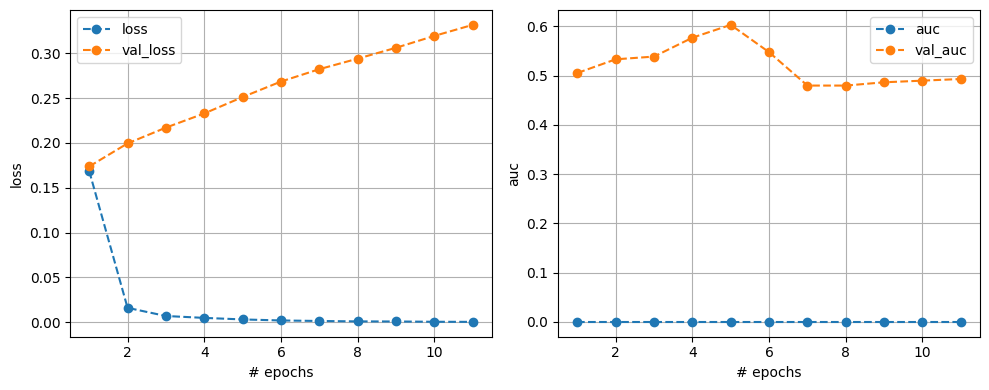

24/24 [==============================] - 3s 137ms/step - loss: 4.1438e-04 - auc: 0.0000e+00 - val_loss: 0.3318 - val_auc: 0.4933


In [19]:
# Extract the best hyperparameters
#best_trial = study.best_trial.params

base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rebuild the model with the best hyperparameters
model = build_model(base_model=base_mobilenet, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Retrain the model
# Note: Depending on your dataset size and model complexity, this may take some time.
history = model.fit(train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               PlotLearning(),
                               tf.keras.callbacks.ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)])

Best threshold: 0.00 with F1-score: 0.14


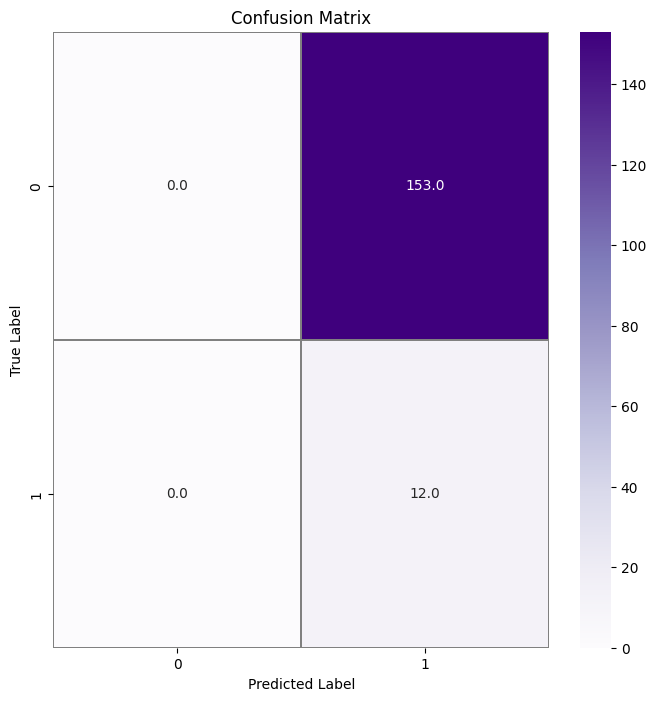

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_47/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.07      1.00      0.14        12

    accuracy                           0.07       165
   macro avg       0.04      0.50      0.07       165
weighted avg       0.01      0.07      0.01       165

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL-tuned  0.26                     0.14      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


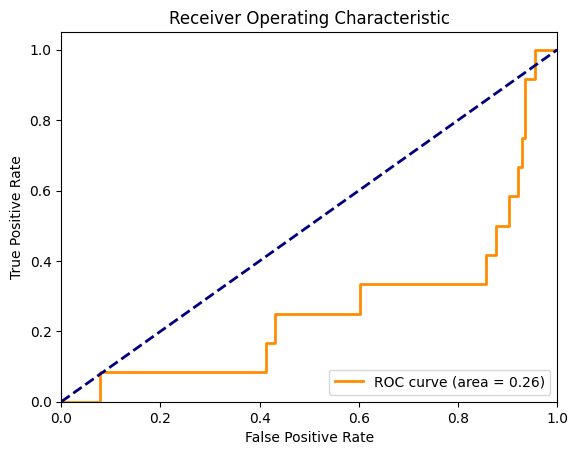

In [20]:
get_model_metrics(test_data=prep_test_data, model=model, model_name='MobileNet-TL-tuned')